In [1]:
# import pismdata as pdata 
import numpy as np
import netCDF4 as nc
import pyfesom2 as pf
import xarray as xr
import matplotlib.pyplot as plt

from matplotlib.tri import Triangulation,TriAnalyzer
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
import cmocean

def calculate_thk_to_sle(thk, resolution = 20000 ):
    ocean_area = 3.625e14  #m^2
    # resolution = 20000  #m
    rhoice = 910 #kg/m^3
    rhosea = 1028 #kg/m^3
    rr = rhoice/rhosea /ocean_area
    # units: m
    aaa = thk * resolution * resolution * rr 
    sle = np.sum(np.sum(aaa,axis=1), axis=1)
    return sle


def dsle_per_year(data, years):
    from scipy.interpolate import UnivariateSpline

    # Fit a spline to the data
    spl = UnivariateSpline(years, data, s=0)
    # Compute the derivative of the spline
    derivative = spl.derivative()(years)

    return derivative




In [12]:
path = '/home/a/a270075/ba0989/awiesm2.5/experiments-2/'
exp = 'tran20-24k-new04'
years = np.arange(-24000, 0, 1)

years2 = np.arange(-24000, 0, 100)
# nyear = len(sle_LIS)
# years2 = years2[0:nyear]

thk = np.zeros((len(years2), 600,600))

## read ice sheet mask file
with nc.Dataset('/home/a/a270075/ba0989/pool/pism/grids/mask_pism_ice_sheet_seperate.nc','r') as ff:
    mask = ff.variables['mask'][:]

# with nc.MFDataset(path+exp+'/outdata/pism/*ts*.nc', 'r') as ff:
with nc.MFDataset(path+exp+'/outdata/pism/*_pismr_extra_*.ymonmean.nc', 'r') as ff:
    data = ff.variables['thk'][:]
    print(data.shape)
    thk[:140,:,:] = data[:140]

exp = 'tran20-10k-new04v2'
with nc.MFDataset(path+exp+'/outdata/pism/*_pismr_extra_*.ymonmean.nc', 'r') as ff:
    data = ff.variables['thk'][:]
    print(data.shape)
    thk[140:,:,:] = data[:]


 ## GIS
data = np.where( (mask==100), thk, 0)
sle_GIS = calculate_thk_to_sle(data)
## LIS  
data = np.where( (mask==200), thk, 0) 
sle_LIS = calculate_thk_to_sle(data)
## CIS  
data = np.where( (mask==300), thk, 0) 
sle_CIS = calculate_thk_to_sle(data)
## EIS  
data = np.where( (mask==400), thk, 0) 
sle_EIS = calculate_thk_to_sle(data)

(206, 600, 600)
(100, 600, 600)


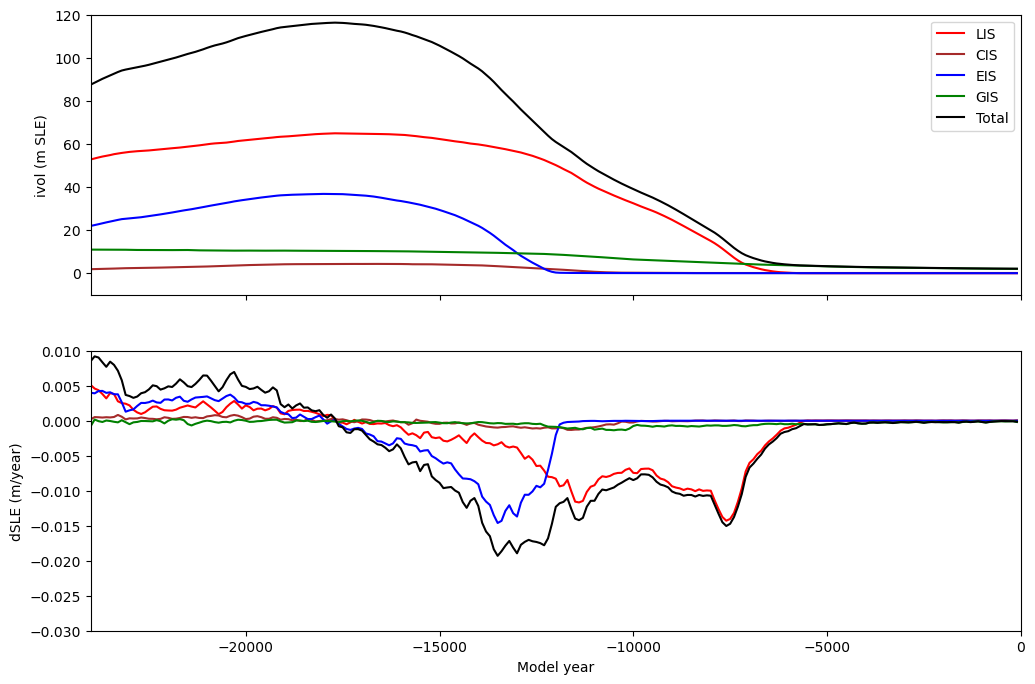

In [16]:


total = sle_LIS + sle_CIS + sle_EIS + sle_GIS
## plotting ####
fig, axs = plt.subplots(2,1, sharex=True, figsize=(12,8) )
axs[0].plot(years2 , sle_LIS, label='LIS',color='red') 
axs[0].plot(years2 , sle_CIS, label='CIS',color='brown') 
axs[0].plot(years2 , sle_EIS, label='EIS',color='blue') 
axs[0].plot(years2 , sle_GIS, label='GIS',color='green') 
axs[0].plot(years2 , total, label='Total',color='black') 



axs[0].legend()

axs[0].set_xlim(-24000, 0)
axs[0].set_ylim(-10, 120)

# axs[0].set_xlabel("Model year", fontsize=10)
axs[0].set_ylabel("ivol (m SLE)", fontsize=10)

axs[1].plot(years2 , dsle_per_year(sle_LIS, years2), label='LIS',color='red') 
axs[1].plot(years2 , dsle_per_year(sle_CIS, years2), label='CIS',color='brown') 
axs[1].plot(years2 , dsle_per_year(sle_EIS, years2), label='EIS',color='blue') 
axs[1].plot(years2 , dsle_per_year(sle_GIS, years2), label='GIS',color='green')
axs[1].plot(years2 , dsle_per_year(total, years2), label='Total',color='black')

axs[1].set_xlabel("Model year", fontsize=10)
axs[1].set_ylabel("dSLE (m/year)", fontsize=10)

axs[1].set_ylim(-0.03, 0.01)

plt.savefig('1_ivol_seperate.png',bbox_inches='tight',)